In [1]:
! pip install -q -U langgraph langchain_core langchain-google-genai

In [8]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import RemoveMessage,trim_messages,HumanMessage,AIMessage
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph import START,END,StateGraph,MessagesState
from IPython.display import Image,display
from dotenv import load_dotenv
import os


load_dotenv()

google_api= os.getenv('GEMINI_API_KEY')


llm:ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model='gemini-1.5-flash',api_key=google_api)




In [7]:
messages = [AIMessage('So you said you were researching ocean mammals?',name='Bot')]
messages.append(HumanMessage('Yes, I know about whales. But what others should I learn about?',name='Lance'))

for n in messages:
    n.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


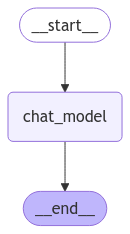

In [9]:
def chat_model(state:MessagesState):
    return {"messages":llm.invoke(state['messages'])}

builder: StateGraph = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
result = graph.invoke({'messages':messages})
for n in result['messages']:
    n.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Besides whales, there's a fascinating world of other ocean mammals to explore!  Here are some groups and examples, categorized for easier learning:

**1. Seals, Sea Lions, and Walruses (Pinnipeds):**

* **Seals (Phocidae):**  Lack external ear flaps, have streamlined bodies for swimming, and tend to be more awkward on land.  Examples include harbor seals, harp seals, leopard seals, and elephant seals.  Learn about their different hunting strategies and adaptations for cold climates.
* **Sea Lions (Otariidae):** Possess external ear flaps, have more prominent foreflippers used for propulsion, and are generally mor

In [21]:
async for m in graph.astream_events({'messages': messages}, version="v2"): # The version argument is now correctly passed as a keyword argument.
      print(m)
      print("\n--------------\n")

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='754e2276-8e0c-4deb-b4b4-6e9fafa5302c'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='08f52b15-0987-450c-ac45-491cbd919bfb')]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '893176b4-c223-43bf-bb43-b79141749740', 'metadata': {}, 'parent_ids': []}

--------------

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='754e2276-8e0c-4deb-b4b4-6e9fafa5302c'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='08f52b15-0987-450c-ac45-491cbd919bfb')]}}, 'name': '__start__', '

### Filtering Messages

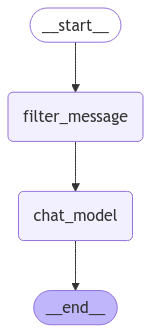

In [42]:
def filter_messages(state:MessagesState):
    delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]
    return {'messages':delete_messages}

def chat_model(state:MessagesState):
    return {'messages':llm.invoke(state['messages'])}

workflow :StateGraph = StateGraph(MessagesState)
workflow.add_node('filter_message',filter_messages)
workflow.add_node('chat_model',chat_model)

workflow.add_edge(START,'filter_message')
workflow.add_edge('filter_message','chat_model')
workflow.add_edge('chat_model',END)

graph:CompiledStateGraph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

output = graph.invoke({'messages': messages})

for m in output['messages']:
    m.pretty_print()


================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're starting with whales!  They're a fascinating group.  Beyond whales, the world of ocean mammals is incredibly diverse. To broaden your research, consider these groups:

**1. Seals, Sea Lions, and Walruses (Pinnipeds):**  This is a large and diverse group with fascinating adaptations for both aquatic and terrestrial life.  Consider focusing on:

* **Differences between seals, sea lions, and walruses:**  Their physical characteristics (flippers, fur, etc.), hunting methods, and social behaviors differ significantly.
* **Adaptations to cold environments:** Many pinnipeds live in frigid waters and 

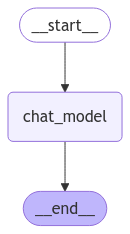

In [47]:
def chat_model(state:MessagesState):
   messages = trim_messages(
       state['messages'],
       max_token =100,
       strategy ='last',
       token_counter = ChatGoogleGenerativeAI(model='gemini-1.5-flash'),
       allow_partial = False )
   
   return {'messages':messages}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [48]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [51]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            token_counter=ChatGoogleGenerativeAI(model='gemini-1.5-flash'),
            strategy="last",
            allow_partial=False
        )

TypeError: trim_messages() missing 1 required keyword-only argument: 'token_counter'